# 1. Install Dependencies and Setup

In [8]:
!pip list

Package                 Version
----------------------- ---------
absl-py                 1.4.0
appnope                 0.1.3
asttokens               2.2.1
astunparse              1.6.3
backcall                0.2.0
cachetools              5.3.1
certifi                 2023.5.7
charset-normalizer      3.1.0
comm                    0.1.3
contourpy               1.0.7
cycler                  0.11.0
debugpy                 1.6.7
decorator               5.1.1
executing               1.2.0
flatbuffers             23.5.26
fonttools               4.39.4
gast                    0.4.0
google-auth             2.19.1
google-auth-oauthlib    1.0.0
google-pasta            0.2.0
grpcio                  1.54.2
h5py                    3.8.0
idna                    3.4
ipykernel               6.23.1
ipython                 8.14.0
jedi                    0.18.2
jupyter_client          8.2.0
jupyter_core            5.3.0
keras                   2.13.1rc0
kiwisolver              1.4.4
libclang            

In [19]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [20]:
import cv2
import imghdr

In [21]:
data_dir = 'data' 

In [22]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [23]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [26]:
data_iterator = data.as_numpy_iterator()

In [27]:
batch = data_iterator.next()

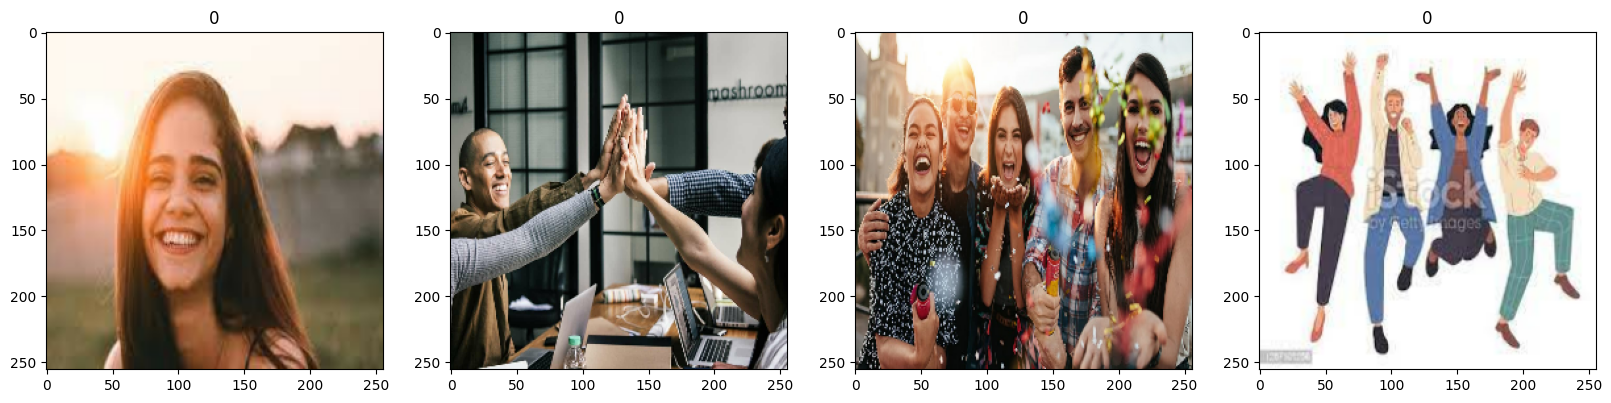

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [29]:
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          ...,
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706]],
 
         [[1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          ...,
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706]],
 
         [[1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          [1.        , 0.9764706 , 0.9372549 ],
          ...,
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706],
          [0.99215686, 0.9529412 , 0.91764706]],
 
         ...,
 
         [[0.42578125, 0.37480086, 0.23754595],
          [0.42652

# 5. Split Data

In [31]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [32]:
train_size

7

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [34]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [40]:
logdir='logs'

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-06-08 08:19:49.480316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.1361 - accuracy: 0.4777

2023-06-08 08:19:54.245100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 340ms/step - loss: 3.1361 - accuracy: 0.4777 - val_loss: 1.7156 - val_accuracy: 0.3906
Epoch 2/20
7/7 [==============================] - 3s 338ms/step - loss: 0.8335 - accuracy: 0.4955 - val_loss: 0.6909 - val_accuracy: 0.4688
Epoch 3/20
7/7 [==============================] - 3s 329ms/step - loss: 0.6844 - accuracy: 0.4821 - val_loss: 0.6710 - val_accuracy: 0.4844
Epoch 4/20
7/7 [==============================] - 3s 329ms/step - loss: 0.6621 - accuracy: 0.5045 - val_loss: 0.6620 - val_accuracy: 0.5781
Epoch 5/20
7/7 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.7009

2023-06-08 08:20:18.393698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 75 of 256
2023-06-08 08:20:19.218166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


7/7 [==============================] - 14s 2s/step - loss: 0.6137 - accuracy: 0.7009 - val_loss: 0.5032 - val_accuracy: 0.7969
Epoch 6/20
7/7 [==============================] - 4s 372ms/step - loss: 0.5346 - accuracy: 0.7009 - val_loss: 0.5184 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 3s 333ms/step - loss: 0.4997 - accuracy: 0.8170 - val_loss: 0.4330 - val_accuracy: 0.9062
Epoch 8/20
7/7 [==============================] - 3s 331ms/step - loss: 0.3956 - accuracy: 0.8438 - val_loss: 0.3496 - val_accuracy: 0.8438
Epoch 9/20
7/7 [==============================] - 3s 331ms/step - loss: 0.3465 - accuracy: 0.8482 - val_loss: 0.3666 - val_accuracy: 0.8750
Epoch 10/20
7/7 [==============================] - 3s 336ms/step - loss: 0.2880 - accuracy: 0.9152 - val_loss: 0.1974 - val_accuracy: 0.9531
Epoch 11/20
7/7 [==============================] - 3s 335ms/step - loss: 0.1928 - accuracy: 0.9196 - val_loss: 0.2002 - val_accuracy: 0.9375
Epoch 12/20
7/7 [==============

# 8. Plot Performance

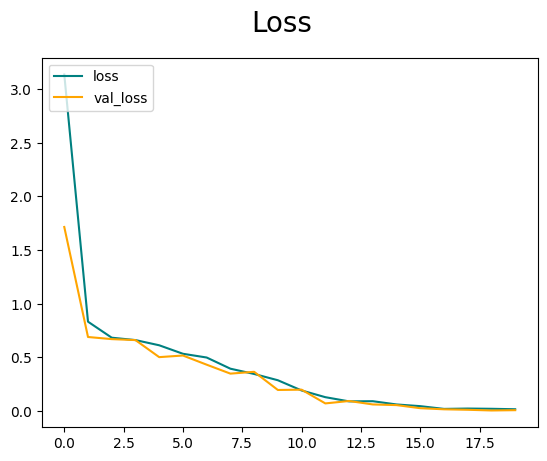

In [43]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

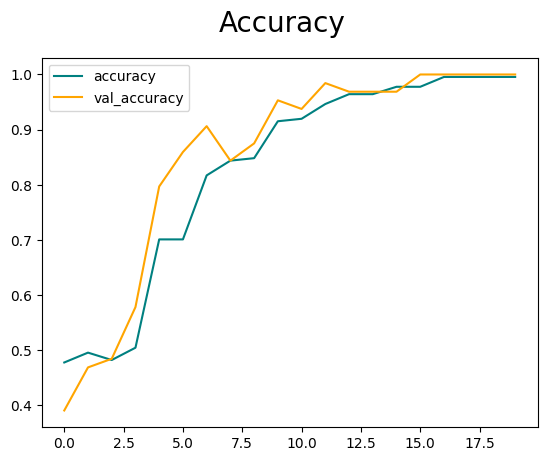

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-06-08 08:23:33.729965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 278ms/step


In [49]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [109]:
import cv2

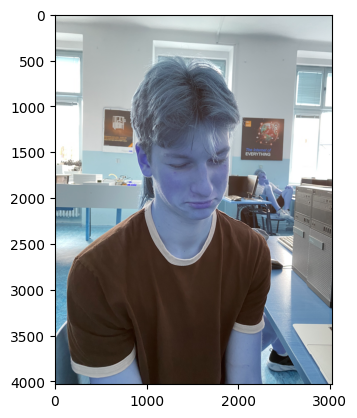

In [110]:
img = cv2.imread('IMG_6476.jpg')
plt.imshow(img)
plt.show()

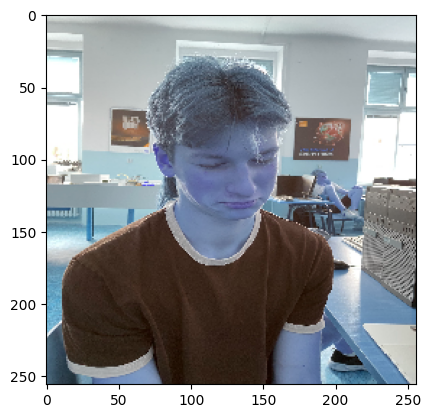

In [111]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [115]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [116]:
yhat

array([[0.92505133]], dtype=float32)

In [117]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [98]:
from tensorflow.keras.models import load_model
import os


In [99]:
model.save(os.path.join('models','imageclassifier.h5'))

In [101]:
new_model = load_model('/Users/vaclavknapp/Desktop/Coding/ImageClassification/models/imageclassifier.h5')

In [102]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 60ms/step


2023-06-08 15:26:02.821819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.9776103]], dtype=float32)